# Africa Wildlife Multi-class Classification

Just playing around with a multi-class classification problem. Nice and simple implementation here using transfer learning with `densenet121`.

We will be using the [African Wildlife Dataset](https://www.kaggle.com/biancaferreira/african-wildlife) which contains ~1500 images of 4 roughly balanced classes: "buffalo", "elephant", "rhino", "zebra".

## Imports

In [1]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, utils, models, datasets
from sklearn.model_selection import train_test_split
from PIL import Image
from urllib.request import urlopen
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16,
                     'axes.labelweight': 'bold',
                     'figure.figsize': (8,6),
                     'axes.grid': False})

## Data Preparation

In [2]:
TRAIN_DIR = "../input/african-wildlife"
IMAGE_SIZE = 256
BATCH_SIZE = 32
torch.manual_seed(123)

# Dataset
data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
# Stratified Sampling
labels = dataset.targets
train_idx, valid_idx= train_test_split(np.arange(len(labels)),
                                       test_size=0.3,
                                       stratify=labels,
                                       random_state=123)        # this is stratified sampling my dataset
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx) # this will tell my dataloader which images are training
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx) # this will tell my dataloader which images are validation
# Loaders
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [3]:
dataset.classes

['buffalo', 'elephant', 'rhino', 'zebra']

In [4]:
# Confirm that our dataset is balanced after sampling
print("Training class distribution")
print(pd.Series(np.array(labels)[train_idx]).value_counts())
print("\nValidation class distribution")
print(pd.Series(np.array(labels)[valid_idx]).value_counts())

Training class distribution
3    263
2    263
1    263
0    263
dtype: int64

Validation class distribution
3    113
2    113
1    113
0    113
dtype: int64


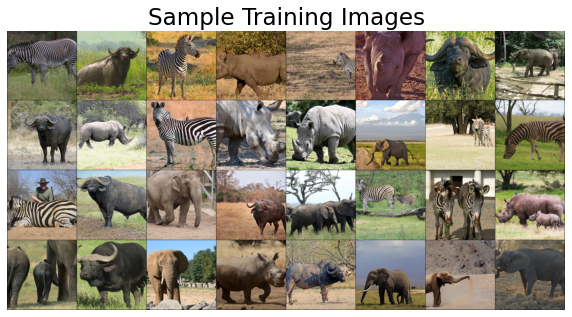

In [5]:
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

## Fine-tuning

In [7]:
# Load (but don't freeze!) the model
densenet = models.densenet121(pretrained=True)
# Replace classification layer
new_layers = nn.Sequential(OrderedDict([
    ('new1', nn.Linear(1024, 300)),
    ('relu', nn.ReLU()),
    ('new2', nn.Linear(300, 4))
]))
densenet.classifier = new_layers
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
densenet.to(device);

In [8]:
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=20, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        train_loss.append(train_batch_loss / len(train_loader))
        train_accuracy.append(valid_batch_acc / len(train_loader))
        
        # Validation
        with torch.no_grad():  # this stops pytorch doing computational graph stuff under-the-hood and saves memory and time
            for X, y in valid_loader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        valid_loss.append(valid_batch_loss / len(valid_loader))
        valid_accuracy.append(valid_batch_acc / len(valid_loader))
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Train Accuracy: {valid_accuracy[-1]:.2f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}.")
    
    results = {"train_loss": train_loss,
               "train_accuracy": train_accuracy,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


In [10]:
# We have a big model so this will take some time to run! If you have a GPU, things could be much faster!
densenet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters())
results = trainer(densenet, criterion, optimizer, train_loader, valid_loader, device, epochs=10)
print("Finished training you handsome devil!")

Epoch 1: Train Loss: 0.390. Train Accuracy: 0.92. Valid Loss: 0.239. Valid Accuracy: 0.92.
Epoch 2: Train Loss: 0.242. Train Accuracy: 0.94. Valid Loss: 0.186. Valid Accuracy: 0.94.
Epoch 3: Train Loss: 0.258. Train Accuracy: 0.95. Valid Loss: 0.167. Valid Accuracy: 0.95.
Epoch 4: Train Loss: 0.137. Train Accuracy: 0.97. Valid Loss: 0.096. Valid Accuracy: 0.97.
Epoch 5: Train Loss: 0.088. Train Accuracy: 0.97. Valid Loss: 0.094. Valid Accuracy: 0.97.
Epoch 6: Train Loss: 0.104. Train Accuracy: 0.98. Valid Loss: 0.066. Valid Accuracy: 0.98.
Epoch 7: Train Loss: 0.111. Train Accuracy: 0.97. Valid Loss: 0.098. Valid Accuracy: 0.97.
Epoch 8: Train Loss: 0.107. Train Accuracy: 0.98. Valid Loss: 0.066. Valid Accuracy: 0.98.
Epoch 9: Train Loss: 0.059. Train Accuracy: 0.98. Valid Loss: 0.070. Valid Accuracy: 0.98.
Epoch 10: Train Loss: 0.087. Train Accuracy: 0.97. Valid Loss: 0.090. Valid Accuracy: 0.97.
Finished training you handsome devil!


## A few tests

In [ ]:
# Put model in eval mode
densenet.to("cpu")
densenet.eval()

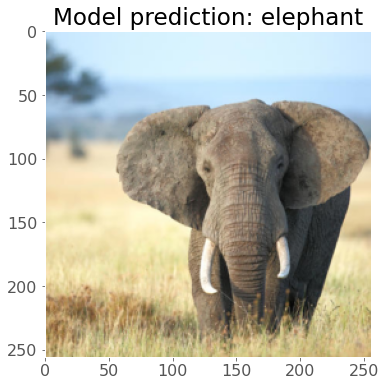

In [28]:
image = Image.open(urlopen('https://assets.nrdc.org/sites/default/files/styles/full_content/public/media-uploads/wlds43_654640_2400.jpg?itok=2eXbSQ8S'))
image = data_transforms(image).unsqueeze(0)
_, image_idx = torch.softmax(densenet(image), dim=1).topk(1)
plt.figure()
plt.imshow(np.transpose(image.squeeze(), (1, 2, 0)))
plt.grid(False)
plt.title(f"Model prediction: {dataset.classes[image_idx.item()]}");

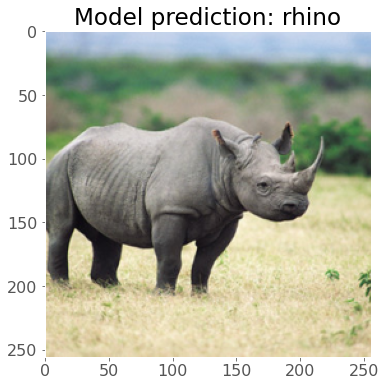

In [29]:
image = Image.open(urlopen('https://media.npr.org/assets/img/2013/12/28/Black%20Rhino-7052256d72b06969c1348a0f9e1c22aa42c88949-s800-c85.jpg'))
image = data_transforms(image).unsqueeze(0)
_, image_idx = torch.softmax(densenet(image), dim=1).topk(1)
plt.figure()
plt.imshow(np.transpose(image.squeeze(), (1, 2, 0)))
plt.grid(False)
plt.title(f"Model prediction: {dataset.classes[image_idx.item()]}");

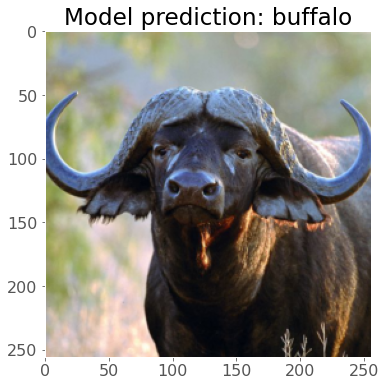

In [30]:
image = Image.open(urlopen('https://i.pinimg.com/originals/12/d6/8f/12d68f83d1b4665568198ea9f3440b66.jpg'))
image = data_transforms(image).unsqueeze(0)
_, image_idx = torch.softmax(densenet(image), dim=1).topk(1)
plt.figure()
plt.imshow(np.transpose(image.squeeze(), (1, 2, 0)))
plt.grid(False)
plt.title(f"Model prediction: {dataset.classes[image_idx.item()]}");

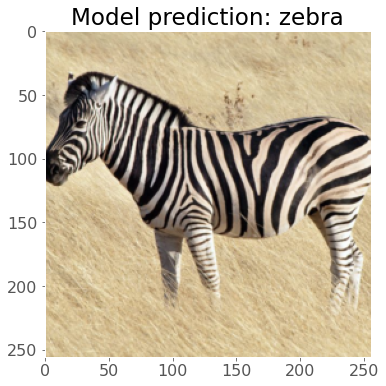

In [33]:
image = Image.open(urlopen('https://s3.amazonaws.com/hudsonalpha/wp-content/uploads/2020/03/31082714/Common_zebra_1-800x600.jpg'))
image = data_transforms(image).unsqueeze(0)
_, image_idx = torch.softmax(densenet(image), dim=1).topk(1)
plt.figure()
plt.imshow(np.transpose(image.squeeze(), (1, 2, 0)))
plt.grid(False)
plt.title(f"Model prediction: {dataset.classes[image_idx.item()]}");